In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [5]:
transform = transforms.Compose([transforms.ToTensor(),
                              ])

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

!mkdir data
trainset = datasets.MNIST('data', download=True, train=True, transform=transform)
valset = datasets.MNIST('data', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

A subdirectory or file data already exists.


In [6]:
class Model(nn.Module):
    def __init__(self, z_dim):
        super().__init__()

        self.encode = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 100),
            nn.GELU(),
            nn.Linear(100, z_dim),
            nn.GELU()
        )

        self.decode = nn.Sequential(
            nn.Linear(z_dim, 100),
            nn.GELU(),
            nn.Linear(100, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(1, (1, 28, 28))
        )

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)
    
class CNN(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        
        self.encode = nn.Sequential(
            # Convolve
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True),
            # Reshape
            nn.Flatten(1),
            # Linear
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, z_dim)
        )
        
        self.decode = nn.Sequential(
            # Linear
            nn.Linear(z_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True),
            # Reshape
            nn.Unflatten(1, (32, 3, 3)),
            # Convolve
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)
    
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):  
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z   

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        # x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [7]:
cnn = CNN(10)
x, _ = next(iter(trainloader))
print(x.shape)
print(cnn.encode(x)[0].shape)
print(cnn(x).shape)

torch.Size([64, 1, 28, 28])
torch.Size([10])
torch.Size([64, 1, 28, 28])


In [8]:
z_dim = 10
model = VariationalAutoencoder(z_dim).to(device)
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

loss_fn = nn.MSELoss()

n_epochs = 50
losses = []
for epoch in tqdm(range(1, n_epochs+1)):
    batch_losses = []
    for x, _ in trainloader:
        x = x.to(device)
        x_hat = model(x)
        
        loss = loss_fn(x_hat, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss.item())
    losses.append(np.mean(batch_losses))
    

100%|██████████| 50/50 [07:08<00:00,  8.58s/it]


In [10]:
losses

[0.057906034972463084,
 0.019806488031851074,
 0.017347044576563116,
 0.016175299413255982,
 0.015496000591943513,
 0.014958074812823014,
 0.014609185351269332,
 0.01428345840241609,
 0.014026217299626708,
 0.013808095948830215,
 0.013625130832775124,
 0.013464164700724486,
 0.01330711612148262,
 0.013173417702539643,
 0.013061005539739374,
 0.012934645385678008,
 0.012835927919220568,
 0.012745024268028897,
 0.012660467862161491,
 0.012586576422291206,
 0.012510068587529889,
 0.012465512047388725,
 0.012382044921567572,
 0.012312577019677933,
 0.012270460554611073,
 0.012228446063408846,
 0.012171332029375568,
 0.012130688402309284,
 0.012076124926206909,
 0.01204987495903299,
 0.011999492352800583,
 0.011952693694269162,
 0.011917618402182611,
 0.011889486837742934,
 0.011873237769812472,
 0.011828863432309203,
 0.01179531709884784,
 0.011768848058392309,
 0.011724407824356037,
 0.011709959024805695,
 0.011698087826291762,
 0.011658340670676755,
 0.011644330758379022,
 0.011607897341

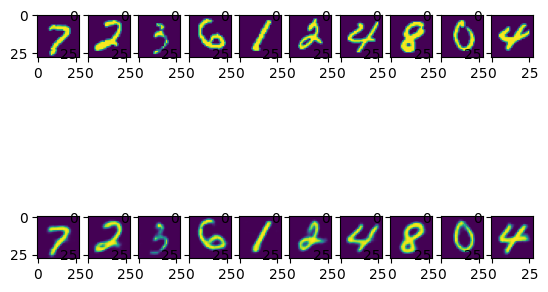

In [11]:
for x, _ in valloader:
    fig, ax = plt.subplots(2, z_dim)
    x = x.to(device)
    x_hat = model(x).cpu().detach().numpy()

    for n in range(10):
        ax[0][n].imshow(x[n][0].cpu())
        ax[1][n].imshow(x_hat[n][0])

    break

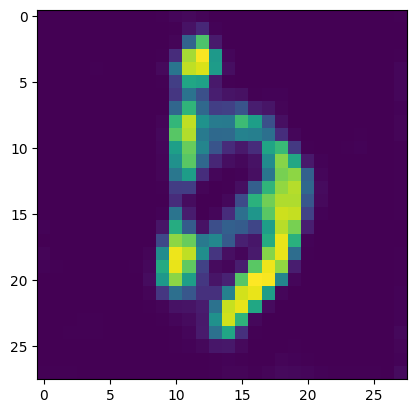

In [52]:
z = torch.randn(1,10).to(device)

plt.imshow(model.decoder(z).cpu().detach().numpy()[0][0])